In [1]:
from fractional_differentiation import find_stat_series
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import itertools
import multiprocess as mp

# Load Data


In [39]:
prices = pd.read_csv("../../data/prices_processed.csv", parse_dates=["date"])

/var/folders/3r/t8b8j58n2hl6cxp_9t3pf6880000gn/T/ipykernel_28319/3840172344.py:1: DtypeWarning: Columns (17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  prices = pd.read_csv("../../data/prices_processed.csv", parse_dates=["date"])


In [40]:
prices.tail(3)

permno       date nameendt  shrcd  exchcd  siccd ticker     comnam  \
3890644   93436 2023-12-27      NaN     11       3   9999   TSLA  TESLA INC   
3890645   93436 2023-12-28      NaN     11       3   9999   TSLA  TESLA INC   
3890646   93436 2023-12-29      NaN     11       3   9999   TSLA  TESLA INC   

        tsymbol     naics  ...   vol_21d ret_vol_adj        mktcap    prc_adj  \
3890644    TSLA  336110.0  ...  0.021262    0.537571  8.310971e+08  261.44000   
3890645    TSLA  336110.0  ...  0.020625   -0.921474  8.048392e+08  253.17999   
3890646    TSLA  336110.0  ...  0.020932   -0.541765  7.898983e+08  248.48000   

         naics_processed  ret_industry_tot  ret_industry_relative MACD_index  \
3890644             33.0          0.106531               0.431040   4.915272   
3890645             33.0          0.008914              -0.930388   5.076989   
3890646             33.0         -0.221914              -0.319851   5.070092   

               rsi in_sp500  
3890644  68.511971        1  
3890645  53.706654        1  
3890646  47.033612        1  

[3 rows x 68 columns]

# Find Non-Stationary Series


In [41]:
# initialize dataframe
# store 1 if the feature for that permno is non-stationary
features = [
    "prc_adj",
    "ret_industry_relative",
    "MACD_index",
    "rsi",
]

non_stat = pd.DataFrame(index=prices["permno"].unique(), columns=features)

non_stat

prc_adj ret_industry_relative MACD_index  rsi
10078     NaN                   NaN        NaN  NaN
10104     NaN                   NaN        NaN  NaN
10107     NaN                   NaN        NaN  NaN
10137     NaN                   NaN        NaN  NaN
10138     NaN                   NaN        NaN  NaN
...       ...                   ...        ...  ...
93159     NaN                   NaN        NaN  NaN
93246     NaN                   NaN        NaN  NaN
93422     NaN                   NaN        NaN  NaN
93429     NaN                   NaN        NaN  NaN
93436     NaN                   NaN        NaN  NaN

[800 rows x 4 columns]

In [42]:
prices.sort_values(by=["permno", "date"], inplace=True)

prices.tail(2)

permno       date nameendt  shrcd  exchcd  siccd ticker     comnam  \
3890645   93436 2023-12-28      NaN     11       3   9999   TSLA  TESLA INC   
3890646   93436 2023-12-29      NaN     11       3   9999   TSLA  TESLA INC   

        tsymbol     naics  ...   vol_21d ret_vol_adj        mktcap    prc_adj  \
3890645    TSLA  336110.0  ...  0.020625   -0.921474  8.048392e+08  253.17999   
3890646    TSLA  336110.0  ...  0.020932   -0.541765  7.898983e+08  248.48000   

         naics_processed  ret_industry_tot  ret_industry_relative MACD_index  \
3890645             33.0          0.008914              -0.930388   5.076989   
3890646             33.0         -0.221914              -0.319851   5.070092   

               rsi in_sp500  
3890645  53.706654        1  
3890646  47.033612        1  

[2 rows x 68 columns]

In [46]:
mask = prices["permno"] == 15404

stationary = find_stat_series(prices.loc[mask, ["MACD_index"]].dropna())

computing ffd with d=0.05, thres=0.01, weights are 
          0
0 -0.011385
1 -0.015438
2 -0.023750
3 -0.050000
4  1.000000
series and width - series shape:  250  - width:  5
proceeding with FFD. range is  range(5, 250)
diff = 0.05, 
        Frac_diff
432287  -1.335411
432288  -1.694162
432289  -2.005385
432290  -2.269796
432291  -2.484885
...           ...
432527   0.035045
432528   0.030880
432529   0.027249
432530   0.024076
432531   0.021300

[245 rows x 1 columns]
---


In [47]:
prices.loc[mask, "MACD_index"]

432281         NaN
432282    0.472393
432283    0.028295
432284   -0.458195
432285   -0.937848
            ...   
432527    0.035408
432528    0.031254
432529    0.027615
432530    0.024427
432531    0.021792
Name: MACD_index, Length: 251, dtype: float64

In [48]:
stationary.reindex(prices.loc[mask, "date"].index)

d=0.05
432281       NaN
432282       NaN
432283       NaN
432284       NaN
432285       NaN
...          ...
432527  0.035045
432528  0.030880
432529  0.027249
432530  0.024076
432531  0.021300

[251 rows x 1 columns]

In [49]:
prices.loc[mask, "MACD_index"] = stationary.reindex(
    prices.loc[mask, "date"].index
).values

In [37]:
prices.loc[mask, "prc_adj"]

3887248          NaN
3887249          NaN
3887250          NaN
3887251          NaN
3887252          NaN
             ...    
3890642    82.503102
3890643    78.508648
3890644    82.643864
3890645    85.918742
3890646    75.339690
Name: prc_adj, Length: 3399, dtype: float64

In [50]:
from ipywidgets import IntProgress
from IPython.display import display

# just to display progress
f = IntProgress(min=0, max=np.prod(non_stat.shape))
display(f)

prices_stat = prices.copy()

diffs = np.linspace(0.05, 1.95, 39)
# iterate through all permnos and features
for permno, feature in itertools.product(non_stat.index, non_stat.columns):
    f.value += 1

    # select the data relative to the permno and feature
    mask = prices["permno"] == permno
    data = prices.loc[mask, [feature]]
    original_index = data.index
    data = data.dropna()

    # handle features which are empty
    if data.empty:
        print(f"there is no data for {permno} - {feature}")
        continue

    print(permno, feature, "\n", data)
    print("-----")
    # check if the series is stationary
    if adfuller(data, regression="ct")[1] > 0.01:
        stat_series = find_stat_series(data, diffs=diffs)
        stat_series = stat_series.reindex(original_index)
        prices_stat.loc[mask, feature] = stat_series.values

IntProgress(value=0, max=3200)

10078 prc_adj 
       prc_adj
0      153.00
1      143.50
2      143.75
3      136.00
4      143.75
...       ...
2526     9.43
2527     9.47
2528     9.46
2529     9.48
2530     9.49

[2531 rows x 1 columns]
-----
computing ffd with d=0.05, thres=0.01, weights are 
          0
0 -0.011385
1 -0.015438
2 -0.023750
3 -0.050000
4  1.000000
series and width - series shape:  2531  - width:  5
proceeding with FFD. range is  range(5, 2531)
diff = 0.05, 
       Frac_diff
5     129.578727
6     143.104589
7     140.481071
8     133.469822
9     139.303282
...          ...
2526    8.462606
2527    8.483106
2528    8.522343
2529    8.510022
2530    8.529378

[2526 rows x 1 columns]
---
computing ffd with d=0.1, thres=0.01, weights are 
          0
0 -0.011094
1 -0.013162
2 -0.016117
3 -0.020662
4 -0.028500
5 -0.045000
6 -0.100000
7  1.000000
series and width - series shape:  2531  - width:  8
proceeding with FFD. range is  range(8, 2531)
diff = 0.1, 
       Frac_diff
8     113.308283
9     119.49

In [51]:
prices_stat.tail()

permno       date nameendt  shrcd  exchcd  siccd ticker     comnam  \
3890642   93436 2023-12-22      NaN     11       3   9999   TSLA  TESLA INC   
3890643   93436 2023-12-26      NaN     11       3   9999   TSLA  TESLA INC   
3890644   93436 2023-12-27      NaN     11       3   9999   TSLA  TESLA INC   
3890645   93436 2023-12-28      NaN     11       3   9999   TSLA  TESLA INC   
3890646   93436 2023-12-29      NaN     11       3   9999   TSLA  TESLA INC   

        tsymbol     naics  ...   vol_21d ret_vol_adj        mktcap    prc_adj  \
3890642    TSLA  336110.0  ...  0.020859   -0.216962  8.028047e+08  82.503102   
3890643    TSLA  336110.0  ...  0.021031    0.460128  8.157429e+08  78.508648   
3890644    TSLA  336110.0  ...  0.021262    0.537571  8.310971e+08  82.643864   
3890645    TSLA  336110.0  ...  0.020625   -0.921474  8.048392e+08  85.918742   
3890646    TSLA  336110.0  ...  0.020932   -0.541765  7.898983e+08  75.339690   

         naics_processed  ret_industry_tot  ret_industry_relative MACD_index  \
3890642             33.0          0.003517              -0.220480   4.421230   
3890643             33.0          0.315202               0.144926   4.636162   
3890644             33.0          0.106531               0.431040   4.915272   
3890645             33.0          0.008914              -0.930388   5.076989   
3890646             33.0         -0.221914              -0.319851   5.070092   

               rsi in_sp500  
3890642  58.473892        1  
3890643  63.398606        1  
3890644  68.511971        1  
3890645  53.706654        1  
3890646  47.033612        1  

[5 rows x 68 columns]

In [53]:
prices_stat.to_csv("../../data/prices_stationary.csv", index=False)

array(['MMI'], dtype=object)

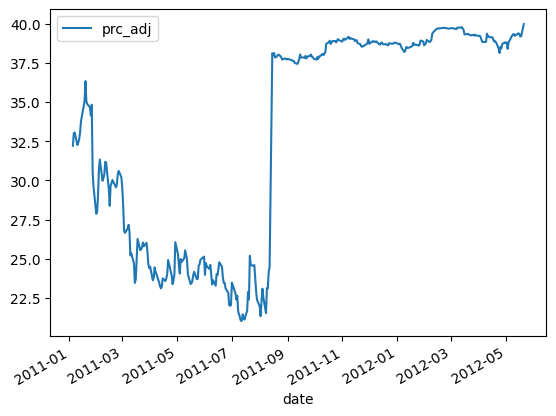

In [18]:
mask = prices["permno"] == 12456
prices.loc[mask].plot(x="date", y="prc_adj")
prices.loc[mask, "ticker"].unique()

In [32]:
mask = prices["permno"] == 12456
mmi = prices.loc[mask].set_index("date")
mmi[mmi.index.year == 2012][["prc", "prc_adj", "in_sp500"]].head(50)

prc  prc_adj  in_sp500
date                                
2012-01-03  38.70    38.70         1
2012-01-04  38.73    38.73         1
2012-01-05  38.61    38.61         1
2012-01-06  38.46    38.46         1
2012-01-09  38.20    38.20         1
2012-01-10  38.27    38.27         1
2012-01-11  38.51    38.51         1
2012-01-12  38.50    38.50         1
2012-01-13  38.45    38.45         1
2012-01-17  38.55    38.55         1
2012-01-18  38.60    38.60         1
2012-01-19  38.78    38.78         1
2012-01-20  38.66    38.66         1
2012-01-23  38.66    38.66         1
2012-01-24  38.64    38.64         1
2012-01-25  38.60    38.60         1
2012-01-26  38.67    38.67         1
2012-01-27  38.93    38.93         1
2012-01-30  38.87    38.87         1
2012-01-31  38.63    38.63         1
2012-02-01  38.67    38.67         1
2012-02-02  38.77    38.77         1
2012-02-03  38.97    38.97         1
2012-02-06  38.83    38.83         1
2012-02-07  38.88    38.88         1
2012-02-08  38.96    38.96         1
2012-02-09  39.35    39.35         1
2012-02-10  39.45    39.45         1
2012-02-13  39.63    39.63         1
2012-02-14  39.68    39.68         1
2012-02-15  39.70    39.70         1
2012-02-16  39.71    39.71         1
2012-02-17  39.70    39.70         1
2012-02-21  39.74    39.74         1
2012-02-22  39.74    39.74         1
2012-02-23  39.73    39.73         1
2012-02-24  39.73    39.73         1
2012-02-27  39.69    39.69         1
2012-02-28  39.69    39.69         1
2012-02-29  39.70    39.70         1
2012-03-01  39.73    39.73         1
2012-03-02  39.73    39.73         1
2012-03-05  39.68    39.68         1
2012-03-06  39.69    39.69         1
2012-03-07  39.66    39.66         1
2012-03-08  39.75    39.75         1
2012-03-09  39.75    39.75         1
2012-03-12  39.76    39.76         1
2012-03-13  39.79    39.79         1
2012-03-14  39.69    39.69         1

In [33]:
non_stat.sum(axis=0)

prc_adj                  772
vol                       53
openprc                  740
askhi                    744
bidlo                    734
bid                      738
ask                      740
numtrd                    35
ret                        0
retx                       0
mktcap                   776
ret_industry_relative      1
MACD_index                 9
rsi                        5
dtype: object

In [41]:
non_stat.to_csv("../../data/non_stat.csv")

# Parallelizing


In [66]:
pd.Series().empty

True

In [76]:
def process_data(permnos: np.ndarray) -> dict[int, dict[str, bool]]:
    print(f"processing {permnos}", flush=True)
    is_stationary: dict[int, dict[str, bool]] = {}

    for permno, feature in itertools.product(permnos, features):
        # select the data relative to the permno and feature
        is_stationary[permno] = {}
        mask = prices["permno"] == permno
        data = prices[mask][feature].dropna()

        # handle features which are empty
        if data.empty:
            print(f"there is no data for {permno} - {feature}")
            is_stationary[permno][feature] = True
            continue

        # check if the series is stationary
        if adfuller(data, regression="ct")[1] > 0.01:
            is_stationary[permno][feature] = False
        else:
            is_stationary[permno][feature] = True

    return is_stationary


def process_permno(permno: int):
    print(f"processing {permno}", flush=True)
    res = {}
    for feature in features:

        mask = prices["permno"] == permno
        data = prices[mask][feature].dropna()

        # handle features which are empty
        if data.empty:
            print(f"there is no data for {permno} - {feature}")
            res[feature] = True

        # check if the series is stationary
        if adfuller(data, regression="ct")[1] > 0.01:
            res[feature] = False
        else:
            res[feature] = True

    return res


def store_results(res: list[dict[int, dict[str, bool]]]):
    for item in res:
        results.update(item)


if __name__ == "__main__":
    results: dict[int, dict[str, bool]] = {}

    ncpus = mp.cpu_count() - 1

    with mp.Pool(ncpus) as p:
        # res = p.map(process_permno, np.array(non_stat.index), chunksize=100)
        res = p.map_async(
            process_data,
            np.array_split(np.array(non_stat.index), ncpus),
            chunksize=100,
        )
        res.get()

        # for permnos in np.array_split(np.array(non_stat.index), ncpus):
        #     res = p.apply(process_data, args=(permnos,))
        #     print(res)

    p.join()

    print(results)

processing [10078 10104 10107 10137 10138 10145 10147 10225 10299 10324 10516 10696
 10909 11081 11308 11403 11404 11533 11552 11600 11618 11674 11703 11754
 11762 11786 11850 11891 11896 11955 11976 12052 12060 12062 12067 12073
 12076 12084 12140 12308 12345 12369 12431 12448 12449 12456 12476 12490
 12542 12558 12570 12622 12623 12650 12872 12981 13035 13103 13141 13142
 13168 13210 13323 13356 13407 13447 13511 13567 13586 13598 13641 13688
 13721 13760 13788 13856 13901 13911 13928 13936 13949 13963 13964 13983
 14008 14011 14277 14295 14297 14338 14541 14542 14579 14593 14601 14656
 14702 14704 14714 14763 14776 14882 14889 14939 15069 15202 15272 15291
 15401 15404 15408 15456 15488 15553 15560]
there is no data for 10137 - numtrd
there is no data for 10147 - numtrd
there is no data for 10225 - numtrd
there is no data for 10516 - numtrd
there is no data for 11308 - numtrd
there is no data for 11404 - numtrd
there is no data for 11533 - numtrd
there is no data for 11674 - numtrd


KeyboardInterrupt: 

In [90]:
from time import sleep
import os


def f(r):
    import numpy as np
    import os
    from time import sleep

    res = np.arange(r[0], r[1])
    print(f"I am {os.getpid()}")
    sleep(10)
    print(f"I am {os.getpid()} and I am finished")
    return {"nums": res, "dubs": res * 2}


# if __name__ == "__main__":
#     ctx = mp.get_context("spawn")
#     with ctx.Pool(4) as p:
#         subsets = [[0, 3], [3, 6], [6, 7]]
#         res = p.map(f, subsets)
#         print(res)

#     print("Done!")

if __name__ == "__main__":
    with mp.Pool(4) as p:
        res = p.map(f, subsets)
        print(res)

I am 10940I am 10938I am 10939




I am 10939 and I am finishedI am 10940 and I am finishedI am 10938 and I am finished


[{'nums': array([0, 1, 2]), 'dubs': array([0, 2, 4])}, {'nums': array([3, 4, 5]), 'dubs': array([ 6,  8, 10])}, {'nums': array([6]), 'dubs': array([12])}]


In [10]:
final: dict[int, dict[str, bool]] = {}


def process_data(permnos: np.ndarray):
    import os

    print(f"initiating process {os.getpid()} - first permno {permnos[0]}\n")

    # stores permno and stationarity for each feature
    is_stationary: dict[int, dict[str, bool]] = {permno: {} for permno in permnos}

    # iterate through each permno and feature
    for permno in permnos:
        mask = prices["permno"] == permno
        permno_data = prices[mask]

        for feature in features:
            feature_data = permno_data[feature].dropna()

            if feature_data.empty:
                print(f"there is no data for {permno} - {feature}")
                is_stationary[permno][feature] = True
                continue

            if adfuller(feature_data, regression="ct")[1] > 0.01:
                is_stationary[permno][feature] = False
            else:
                is_stationary[permno][feature] = True

    return is_stationary


if __name__ == "__main__":
    ncpus = mp.cpu_count() - 1
    print(f"running with {ncpus} cpus")

    with mp.Pool(ncpus) as p:
        permnos_split = np.array_split(np.array(non_stat.index), ncpus)

        res: list[dict[int, dict[str, bool]]] = p.map(process_data, permnos_split)

        if not isinstance(res, list):
            raise Exception("res is not a list")

        for item in res:
            final.update(res)

running with 7 cpus
initiating process 11889 - first permno 49154
initiating process 11886 - first permno 10078
initiating process 11892 - first permno 88991
initiating process 11888 - first permno 24109
initiating process 11887 - first permno 15579
initiating process 11891 - first permno 81696
initiating process 11890 - first permno 75341







there is no data for 88991 - numtrd
there is no data for 75341 - numtrd
there is no data for 49154 - numtrd
there is no data for 24174 - numtrd
there is no data for 24175 - numtrd
there is no data for 89002 - numtrd
there is no data for 15707 - numtrd
there is no data for 49373 - numtrd
there is no data for 24205 - numtrd
there is no data for 81736 - numtrd
there is no data for 15719 - numtrd
there is no data for 89003 - numtrd


KeyboardInterrupt: 

# Fixing Stationarity
